# Preprocessing

## 1: Import & Load Data
Import library dan load metadata dari CSV.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import seaborn as sns

print("✅ Libraries imported!")

# Load metadata
try:
    metadata_df = pd.read_csv("audio_metadata.csv")
    print(f"📊 Loaded {len(metadata_df)} audio files")
    
    # Check available columns in the dataframe
    print(f"\n📋 AVAILABLE COLUMNS: {list(metadata_df.columns)}")
    
    # Display appropriate columns based on what's available
    if all(col in metadata_df.columns for col in ['filename', 'dataset_type', 'speaker', 'command', 'duration']):
        print("\n📊 METADATA PREVIEW:")
        print(metadata_df[['filename', 'dataset_type', 'speaker', 'command', 'duration']].head())
    elif all(col in metadata_df.columns for col in ['filename', 'speaker', 'command', 'duration']):
        print("\n📊 METADATA PREVIEW:")
        print(metadata_df[['filename', 'speaker', 'command', 'duration']].head())
    elif 'filename' in metadata_df.columns:
        # Show whatever columns are available
        available_cols = ['filename'] + [col for col in ['dataset_type', 'speaker', 'command', 'duration'] 
                                       if col in metadata_df.columns]
        print(f"\n📊 METADATA PREVIEW (available columns):")
        print(metadata_df[available_cols].head())
    else:
        print("\n📊 METADATA PREVIEW:")
        print(metadata_df.head())
        
    # Show dataset distribution
    if 'dataset_type' in metadata_df.columns:
        print(f"\n📈 DATASET DISTRIBUTION:")
        for dataset_type in metadata_df['dataset_type'].unique():
            count = len(metadata_df[metadata_df['dataset_type'] == dataset_type])
            print(f"   {dataset_type}: {count} files")
    
    if 'speaker' in metadata_df.columns:
        print(f"\n👥 SPEAKER DISTRIBUTION:")
        for speaker in metadata_df['speaker'].unique():
            count = len(metadata_df[metadata_df['speaker'] == speaker])
            print(f"   {speaker}: {count} files")
    
    if 'command' in metadata_df.columns:
        print(f"\n🎯 COMMAND DISTRIBUTION:")
        for command in metadata_df['command'].unique():
            count = len(metadata_df[metadata_df['command'] == command])
            print(f"   {command}: {count} files")
            
except FileNotFoundError:
    print("❌ File 'audio_metadata.csv' not found!")
    print("💡 Please run the metadata collection function first.")
    metadata_df = pd.DataFrame()
except Exception as e:
    print(f"❌ Error loading metadata: {e}")
    metadata_df = pd.DataFrame()

✅ Libraries imported!
📊 Loaded 400 audio files

📋 AVAILABLE COLUMNS: ['filename', 'file_path', 'dataset_type', 'speaker', 'command', 'duration', 'sample_rate', 'num_samples']

📊 METADATA PREVIEW:
       filename dataset_type speaker command  duration
0  buka_060.wav        train    asep    Buka     1.704
1  buka_044.wav        train    asep    Buka     1.296
2  buka_064.wav        train    asep    Buka     1.296
3  buka_029.wav        train    asep    Buka     1.296
4  buka_021.wav        train    asep    Buka     1.632

📈 DATASET DISTRIBUTION:
   train: 300 files
   val: 100 files

👥 SPEAKER DISTRIBUTION:
   asep: 200 files
   yotan: 200 files

🎯 COMMAND DISTRIBUTION:
   Buka: 200 files
   Tutup: 200 files



## 2: Visualisasi Distribusi Durasi  
Menampilkan distribusi durasi audio per kelas dan split.


📈 VISUALISASI DISTRIBUSI DURASI
📋 Kolom yang tersedia: ['filename', 'file_path', 'dataset_type', 'speaker', 'command', 'duration', 'sample_rate', 'num_samples']


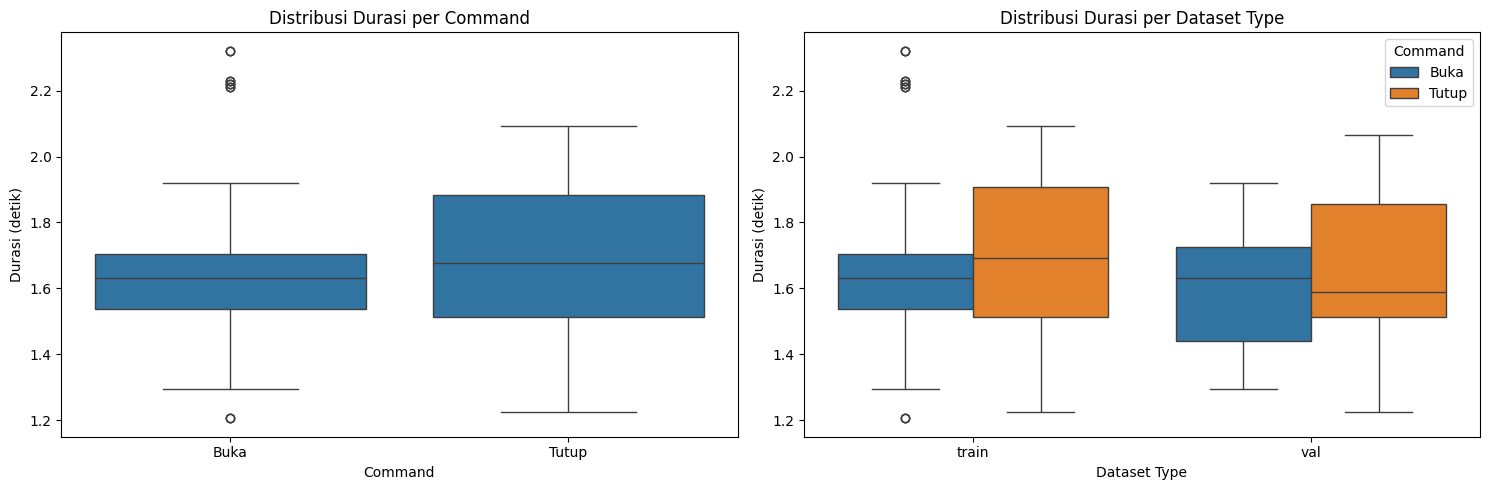


📊 STATISTIK DURASI:
         count   mean    std    min    25%    50%    75%    max
command                                                        
Buka     200.0  1.626  0.228  1.206  1.536  1.632  1.704  2.321
Tutup    200.0  1.673  0.256  1.224  1.512  1.678  1.883  2.093

📊 STATISTIK DURASI PER DATASET TYPE:

🎯 TRAIN:
         count   mean    std    min    25%    50%    75%    max
command                                                        
Buka     150.0  1.631  0.241  1.206  1.536  1.632  1.704  2.321
Tutup    150.0  1.680  0.257  1.224  1.512  1.691  1.909  2.093

🎯 VAL:
         count   mean    std    min    25%    50%    75%    max
command                                                        
Buka      50.0  1.610  0.185  1.296  1.439  1.632  1.724  1.918
Tutup     50.0  1.653  0.256  1.224  1.512  1.589  1.856  2.064

📈 VISUALISASI TAMBAHAN: DISTRIBUSI DURASI PER SPEAKER


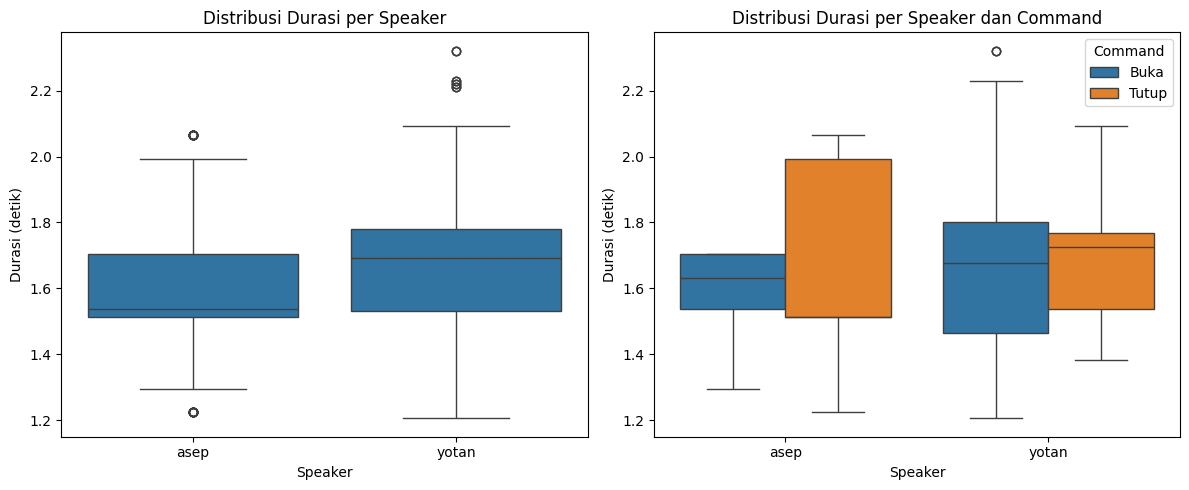


📊 STATISTIK DURASI PER SPEAKER:
         count   mean    std    min    25%    50%    75%    max
speaker                                                        
asep     200.0  1.616  0.255  1.224  1.512  1.536  1.704  2.064
yotan    200.0  1.684  0.227  1.206  1.532  1.692  1.781  2.321


In [12]:
print("📈 VISUALISASI DISTRIBUSI DURASI")
print("=" * 40)

# Check available columns
print(f"📋 Kolom yang tersedia: {list(metadata_df.columns)}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribusi durasi by command (menggantikan 'class')
if 'command' in metadata_df.columns and 'duration' in metadata_df.columns:
    sns.boxplot(data=metadata_df, x='command', y='duration', ax=axes[0])
    axes[0].set_title('Distribusi Durasi per Command')
    axes[0].set_ylabel('Durasi (detik)')
    axes[0].set_xlabel('Command')
else:
    axes[0].text(0.5, 0.5, 'Data command tidak tersedia', 
                horizontalalignment='center', verticalalignment='center', 
                transform=axes[0].transAxes)
    axes[0].set_title('Distribusi Durasi per Command')

# Plot 2: Distribusi durasi by dataset_type (menggantikan 'split')
if 'dataset_type' in metadata_df.columns and 'duration' in metadata_df.columns and 'command' in metadata_df.columns:
    sns.boxplot(data=metadata_df, x='dataset_type', y='duration', hue='command', ax=axes[1])
    axes[1].set_title('Distribusi Durasi per Dataset Type')
    axes[1].set_ylabel('Durasi (detik)')
    axes[1].set_xlabel('Dataset Type')
    axes[1].legend(title='Command')
elif 'dataset_type' in metadata_df.columns and 'duration' in metadata_df.columns:
    sns.boxplot(data=metadata_df, x='dataset_type', y='duration', ax=axes[1])
    axes[1].set_title('Distribusi Durasi per Dataset Type')
    axes[1].set_ylabel('Durasi (detik)')
    axes[1].set_xlabel('Dataset Type')
else:
    axes[1].text(0.5, 0.5, 'Data dataset_type tidak tersedia', 
                horizontalalignment='center', verticalalignment='center', 
                transform=axes[1].transAxes)
    axes[1].set_title('Distribusi Durasi per Dataset Type')

plt.tight_layout()
plt.show()

# Statistik durasi
print("\n📊 STATISTIK DURASI:")
if 'command' in metadata_df.columns and 'duration' in metadata_df.columns:
    duration_stats = metadata_df.groupby('command')['duration'].describe()
    print(duration_stats.round(3))
    
    # Tambahan: statistik by dataset_type
    if 'dataset_type' in metadata_df.columns:
        print(f"\n📊 STATISTIK DURASI PER DATASET TYPE:")
        for dataset_type in metadata_df['dataset_type'].unique():
            print(f"\n🎯 {dataset_type.upper()}:")
            dataset_stats = metadata_df[metadata_df['dataset_type'] == dataset_type].groupby('command')['duration'].describe()
            print(dataset_stats.round(3))
else:
    print("❌ Data 'command' atau 'duration' tidak tersedia untuk statistik")
    if 'duration' in metadata_df.columns:
        print("\n📊 STATISTIK DURASI KESELURUHAN:")
        print(metadata_df['duration'].describe().round(3))

# Visualisasi tambahan: Distribusi durasi by speaker
if 'speaker' in metadata_df.columns and 'duration' in metadata_df.columns:
    print(f"\n📈 VISUALISASI TAMBAHAN: DISTRIBUSI DURASI PER SPEAKER")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=metadata_df, x='speaker', y='duration')
    plt.title('Distribusi Durasi per Speaker')
    plt.ylabel('Durasi (detik)')
    plt.xlabel('Speaker')
    
    plt.subplot(1, 2, 2)
    if 'command' in metadata_df.columns:
        sns.boxplot(data=metadata_df, x='speaker', y='duration', hue='command')
        plt.title('Distribusi Durasi per Speaker dan Command')
        plt.ylabel('Durasi (detik)')
        plt.xlabel('Speaker')
        plt.legend(title='Command')
    else:
        sns.violinplot(data=metadata_df, x='speaker', y='duration')
        plt.title('Distribusi Durasi per Speaker (Violin Plot)')
        plt.ylabel('Durasi (detik)')
        plt.xlabel('Speaker')
    
    plt.tight_layout()
    plt.show()
    
    # Statistik durasi by speaker
    print(f"\n📊 STATISTIK DURASI PER SPEAKER:")
    speaker_stats = metadata_df.groupby('speaker')['duration'].describe()
    print(speaker_stats.round(3))


## 3: Extract Features
Melakukan ekstraksi fitur MFCC dari file audio.


In [13]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    """Extract features dari audio file"""
    try:
        y, sr = librosa.load(file_path, sr=sr)
        
        # MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # Additional features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        rms_energy = np.mean(librosa.feature.rms(y=y))
        
        # Combine features
        features = np.concatenate([
            mfcc_mean,
            mfcc_std,
            [spectral_centroid, zero_crossing_rate, chroma_stft, rms_energy]
        ])
        
        return features
        
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

print("🔧 EXTRACTING FEATURES...")
print("=" * 40)

# Check available columns
print(f"📋 Available columns: {list(metadata_df.columns)}")

features = []
labels = []
file_paths = []
failed_files = []

# Determine the target column for labels
if 'command' in metadata_df.columns:
    target_column = 'command'  # Use 'command' (Buka/Tutup) as class label
    print("🎯 Using 'command' column as labels")
elif 'class' in metadata_df.columns:
    target_column = 'class'
    print("🎯 Using 'class' column as labels")
else:
    print("❌ No suitable label column found! Available columns:", list(metadata_df.columns))
    X, y = np.array([]), np.array([])

# Check if file_path column exists
if 'file_path' not in metadata_df.columns:
    print("❌ 'file_path' column not found in metadata!")
    # Try to reconstruct file_path if possible
    if all(col in metadata_df.columns for col in ['filename', 'dataset_type', 'speaker', 'command']):
        print("💡 Reconstructing file paths...")
        metadata_df['file_path'] = metadata_df.apply(lambda row: 
            f"Audio/{row['dataset_type']}/audio_output_{row['speaker']}/{row['command']}/{row['filename']}", 
            axis=1
        )
    else:
        print("❌ Cannot reconstruct file paths. Required columns missing.")
        X, y = np.array([]), np.array([])

if 'file_path' in metadata_df.columns and 'target_column' in locals():
    for idx, row in metadata_df.iterrows():
        if idx % 50 == 0:
            print(f"📁 Processed {idx}/{len(metadata_df)} files...")
        
        feature_vector = extract_features(row['file_path'])
        if feature_vector is not None:
            features.append(feature_vector)
            labels.append(row[target_column])
            file_paths.append(row['file_path'])
        else:
            failed_files.append(row['file_path'])
    
    if features:
        X = np.array(features)
        y = np.array(labels)
        
        print(f"\n✅ Feature extraction completed!")
        print(f"📊 Features shape: {X.shape}")
        print(f"🎯 Labels shape: {y.shape}")
        print(f"📁 Successful files: {len(features)}")
        print(f"❌ Failed files: {len(failed_files)}")
        
        if failed_files:
            print(f"\n⚠️  Failed to process these files:")
            for failed_file in failed_files[:5]:  # Show first 5 failed files
                print(f"   - {failed_file}")
            if len(failed_files) > 5:
                print(f"   ... and {len(failed_files) - 5} more")
        
        # Show label distribution
        print(f"\n📈 LABEL DISTRIBUTION:")
        unique_labels, counts = np.unique(y, return_counts=True)
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(y)) * 100
            print(f"   {label}: {count} files ({percentage:.1f}%)")
        
        # Show feature statistics
        print(f"\n📊 FEATURE STATISTICS:")
        print(f"   Number of features: {X.shape[1]}")
        print(f"   Feature range: [{X.min():.3f}, {X.max():.3f}]")
        print(f"   Mean: {X.mean():.3f}, Std: {X.std():.3f}")
        
    else:
        print("❌ No features extracted successfully!")
        X, y = np.array([]), np.array([])
else:
    print("❌ Cannot proceed with feature extraction due to missing data.")
    X, y = np.array([]), np.array([])

🔧 EXTRACTING FEATURES...
📋 Available columns: ['filename', 'file_path', 'dataset_type', 'speaker', 'command', 'duration', 'sample_rate', 'num_samples']
🎯 Using 'command' column as labels
📁 Processed 0/400 files...
📁 Processed 50/400 files...
📁 Processed 100/400 files...
📁 Processed 150/400 files...
📁 Processed 200/400 files...
📁 Processed 250/400 files...
📁 Processed 300/400 files...
📁 Processed 350/400 files...

✅ Feature extraction completed!
📊 Features shape: (400, 30)
🎯 Labels shape: (400,)
📁 Successful files: 400
❌ Failed files: 0

📈 LABEL DISTRIBUTION:
   Buka: 200 files (50.0%)
   Tutup: 200 files (50.0%)

📊 FEATURE STATISTICS:
   Number of features: 30
   Feature range: [-318.037, 4170.524]
   Mean: 83.449, Std: 473.015



## 5: Visualisasi Features
Menampilkan distribusi dan hubungan antar fitur.


📊 VISUALISASI FEATURES


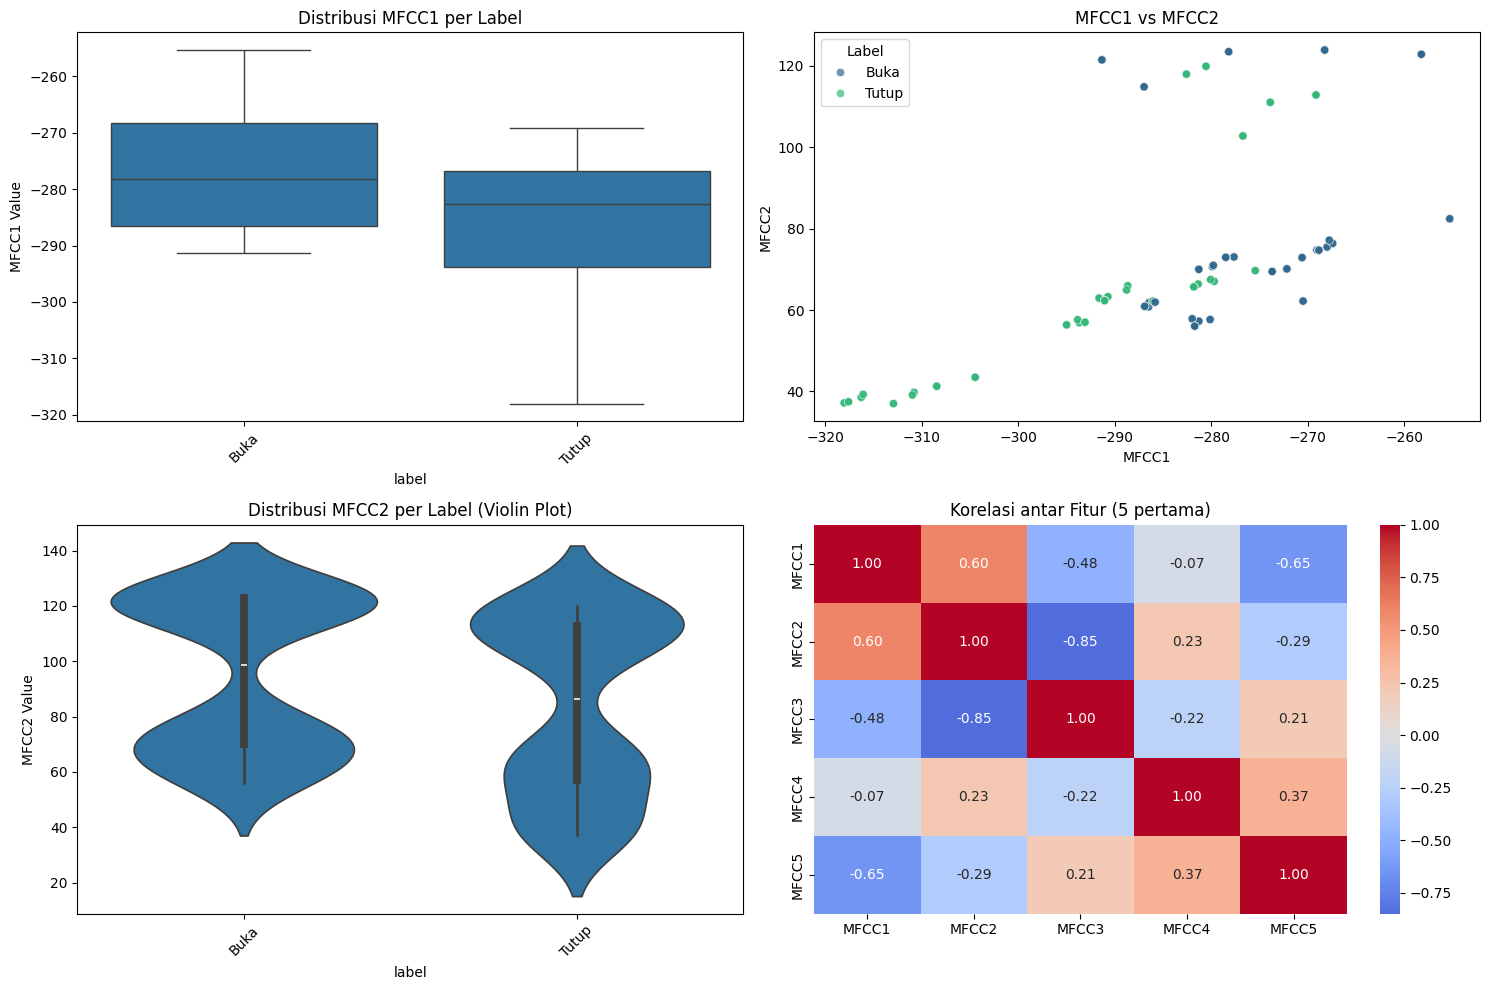


📊 STATISTIK FITUR PER LABEL:
-----------------------------------
MFCC1 Statistics:
       count     mean     std      min      25%      50%      75%      max
label                                                                     
Buka   200.0 -276.633  10.119 -291.344 -286.475 -278.207 -268.267 -255.311
Tutup  200.0 -287.550  14.954 -318.037 -293.860 -282.589 -276.737 -269.167

📋 INFORMASI FITUR:
   Shape features: (400, 30)
   Jumlah fitur: 30
   Jumlah sample: 400
   Labels: ['Buka' 'Tutup']

🎯 DISTRIBUSI LABEL:
   Buka: 200 samples (50.0%)
   Tutup: 200 samples (50.0%)


In [14]:
print("📊 VISUALISASI FEATURES")
print("=" * 40)

# Check if we have features and labels
if 'X' in locals() and 'y' in locals() and len(X) > 0 and len(y) > 0:
    # Create feature DataFrame untuk visualisasi
    # Use first 5 MFCC features + additional features for visualization
    n_mfcc_features = 13  # Assuming we extracted 13 MFCC features
    feature_names = [f'MFCC{i+1}' for i in range(min(5, n_mfcc_features))]
    
    # If we have more than 5 MFCC features, take first 5
    if X.shape[1] > len(feature_names):
        feature_df = pd.DataFrame(X[:, :5], columns=feature_names)
    else:
        feature_df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])
    
    feature_df['label'] = y

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Distribusi MFCC1 by label
    if 'MFCC1' in feature_df.columns:
        sns.boxplot(data=feature_df, x='label', y='MFCC1', ax=axes[0, 0])
        axes[0, 0].set_title('Distribusi MFCC1 per Label')
        axes[0, 0].set_ylabel('MFCC1 Value')
        axes[0, 0].tick_params(axis='x', rotation=45)
    else:
        axes[0, 0].text(0.5, 0.5, 'MFCC1 tidak tersedia', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Distribusi MFCC1 per Label')

    # Plot 2: Scatter plot MFCC1 vs MFCC2
    if all(col in feature_df.columns for col in ['MFCC1', 'MFCC2']):
        sns.scatterplot(data=feature_df, x='MFCC1', y='MFCC2', hue='label', 
                       ax=axes[0, 1], alpha=0.7, palette='viridis')
        axes[0, 1].set_title('MFCC1 vs MFCC2')
        axes[0, 1].legend(title='Label')
    else:
        axes[0, 1].text(0.5, 0.5, 'MFCC1/MFCC2 tidak tersedia', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('MFCC1 vs MFCC2')

    # Plot 3: Distribusi MFCC2 by label
    if 'MFCC2' in feature_df.columns:
        sns.violinplot(data=feature_df, x='label', y='MFCC2', ax=axes[1, 0])
        axes[1, 0].set_title('Distribusi MFCC2 per Label (Violin Plot)')
        axes[1, 0].set_ylabel('MFCC2 Value')
        axes[1, 0].tick_params(axis='x', rotation=45)
    else:
        axes[1, 0].text(0.5, 0.5, 'MFCC2 tidak tersedia', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Distribusi MFCC2 per Label')

    # Plot 4: Correlation heatmap of first 5 features
    if len(feature_df.columns) > 1:
        numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            correlation_matrix = feature_df[numeric_cols].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                       ax=axes[1, 1], fmt='.2f')
            axes[1, 1].set_title('Korelasi antar Fitur (5 pertama)')
        else:
            axes[1, 1].text(0.5, 0.5, 'Tidak cukup fitur numerik', 
                           horizontalalignment='center', verticalalignment='center',
                           transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Korelasi antar Fitur')
    else:
        axes[1, 1].text(0.5, 0.5, 'Tidak cukup kolom untuk korelasi', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Korelasi antar Fitur')

    plt.tight_layout()
    plt.show()

    # Additional: Feature statistics by label
    print(f"\n📊 STATISTIK FITUR PER LABEL:")
    print("-" * 35)
    
    if 'MFCC1' in feature_df.columns:
        mfcc1_stats = feature_df.groupby('label')['MFCC1'].describe()
        print("MFCC1 Statistics:")
        print(mfcc1_stats.round(3))
    
    # Feature information
    print(f"\n📋 INFORMASI FITUR:")
    print(f"   Shape features: {X.shape}")
    print(f"   Jumlah fitur: {X.shape[1]}")
    print(f"   Jumlah sample: {X.shape[0]}")
    print(f"   Labels: {np.unique(y)}")
    
    # Label distribution
    print(f"\n🎯 DISTRIBUSI LABEL:")
    unique_labels, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(y)) * 100
        print(f"   {label}: {count} samples ({percentage:.1f}%)")

else:
    print("❌ Features (X) dan labels (y) tidak tersedia!")
    print("💡 Pastikan ekstraksi fitur telah berjalan dengan sukses.")
    
    # Check what variables are available
    available_vars = [var for var in ['X', 'y'] if var in locals()]
    print(f"📋 Variabel yang tersedia: {available_vars}")
    
    if 'X' in locals():
        print(f"   X shape: {X.shape if len(X) > 0 else 'empty'}")
    if 'y' in locals():
        print(f"   y shape: {y.shape if len(y) > 0 else 'empty'}")


## 5: Preprocessing & Standardization
Melakukan standardisasi fitur dan split data.


⚙️ PREPROCESSING & STANDARDIZATION
🎯 Label mapping: {'Buka': 0, 'Tutup': 1}
✅ Using 'dataset_type' column for train/val split

📊 DATA SPLIT SUMMARY:
   Training set: 300 samples
   Validation set: 100 samples
   Feature dimension: 30

🎯 LABEL DISTRIBUTION:
   TRAIN: Buka: 150 (50.0%)  Tutup: 150 (50.0%)  
   VAL:   Buka: 50 (50.0%)  Tutup: 50 (50.0%)  

📊 FEATURE SCALING:
   Before scaling - Train mean: 83.0309, std: 470.1448
   Before scaling - Val mean: 84.7043, std: 481.5206
   After scaling - Train mean: 0.0000, std: 1.0000
   After scaling - Val mean: 0.0100, std: 1.0169


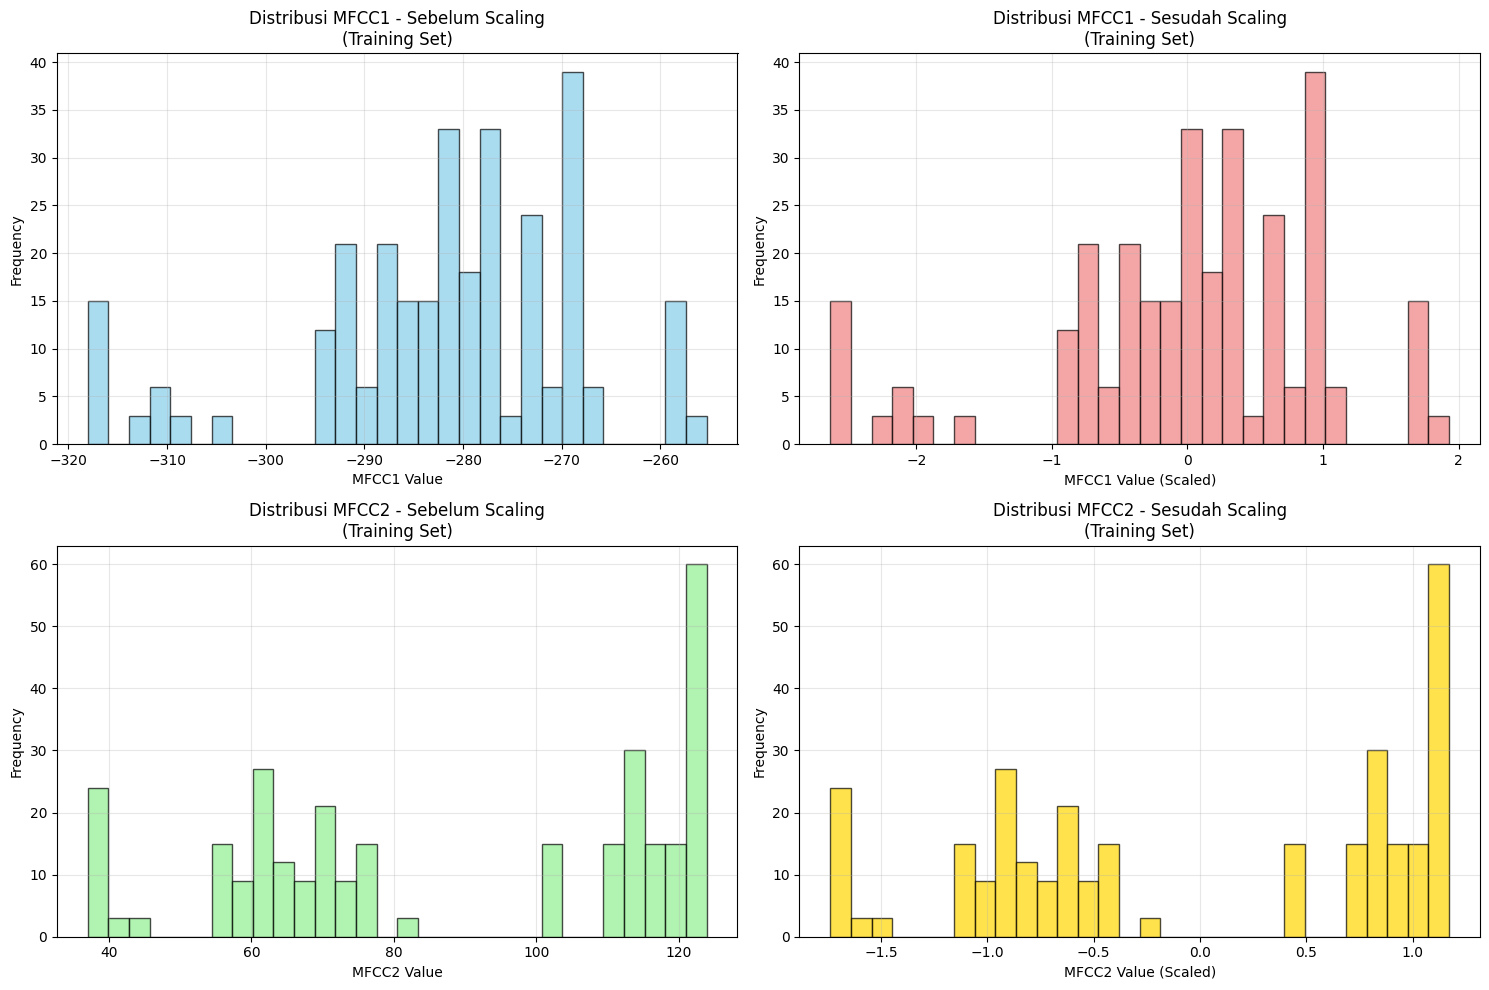


💾 Preprocessing objects saved:
   - label_encoder.pkl
   - scaler.pkl

✅ PREPROCESSING COMPLETED!


In [15]:
print("⚙️ PREPROCESSING & STANDARDIZATION")
print("=" * 40)

# Check available data
if 'X' not in locals() or 'y' not in locals() or len(X) == 0 or len(y) == 0:
    print("❌ Features (X) atau labels (y) tidak tersedia!")
    print("💡 Pastikan ekstraksi fitur telah berjalan dengan sukses.")
else:
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"🎯 Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Split data berdasarkan dataset_type dari metadata
    # Pastikan metadata_df memiliki indeks yang sesuai dengan X dan y
    if 'metadata_df' in locals() and len(metadata_df) >= len(X):
        # Use dataset_type column instead of split
        if 'dataset_type' in metadata_df.columns:
            train_mask = metadata_df.iloc[:len(X)]['dataset_type'] == 'train'
            X_train = X[train_mask]
            X_val = X[~train_mask]
            y_train = y_encoded[train_mask]
            y_val = y_encoded[~train_mask]
            
            print(f"✅ Using 'dataset_type' column for train/val split")
        else:
            print("❌ Column 'dataset_type' not found in metadata!")
            print("💡 Available columns:", list(metadata_df.columns))
            
            # Fallback: split manually 80/20
            from sklearn.model_selection import train_test_split
            X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
            print("✅ Using manual 80/20 train/val split")
    else:
        print("❌ metadata_df tidak tersedia atau tidak sesuai panjangnya dengan X")
        print("💡 Using manual train/test split instead...")
        
        # Fallback: split manually
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    print(f"\n📊 DATA SPLIT SUMMARY:")
    print(f"   Training set: {X_train.shape[0]} samples")
    print(f"   Validation set: {X_val.shape[0]} samples")
    print(f"   Feature dimension: {X_train.shape[1]}")

    # Check label distribution in splits
    if 'y_train' in locals() and 'y_val' in locals():
        print(f"\n🎯 LABEL DISTRIBUTION:")
        train_unique, train_counts = np.unique(y_train, return_counts=True)
        val_unique, val_counts = np.unique(y_val, return_counts=True)
        
        print(f"   TRAIN: ", end="")
        for label, count in zip(train_unique, train_counts):
            original_label = label_encoder.inverse_transform([label])[0]
            percentage = (count / len(y_train)) * 100
            print(f"{original_label}: {count} ({percentage:.1f}%)  ", end="")
        print()
        
        print(f"   VAL:   ", end="")
        for label, count in zip(val_unique, val_counts):
            original_label = label_encoder.inverse_transform([label])[0]
            percentage = (count / len(y_val)) * 100
            print(f"{original_label}: {count} ({percentage:.1f}%)  ", end="")
        print()

    # Standardize features
    print(f"\n📊 FEATURE SCALING:")
    print(f"   Before scaling - Train mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
    print(f"   Before scaling - Val mean: {X_val.mean():.4f}, std: {X_val.std():.4f}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    print(f"   After scaling - Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
    print(f"   After scaling - Val mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")

    # Visualisasi sebelum dan sesudah scaling
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Before scaling - MFCC1
    if X_train.shape[1] > 0:
        axes[0, 0].hist(X_train[:, 0], alpha=0.7, bins=30, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Distribusi MFCC1 - Sebelum Scaling\n(Training Set)')
        axes[0, 0].set_xlabel('MFCC1 Value')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(True, alpha=0.3)

    # After scaling - MFCC1
    axes[0, 1].hist(X_train_scaled[:, 0], alpha=0.7, bins=30, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Distribusi MFCC1 - Sesudah Scaling\n(Training Set)')
    axes[0, 1].set_xlabel('MFCC1 Value (Scaled)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

    # Before scaling - MFCC2
    if X_train.shape[1] > 1:
        axes[1, 0].hist(X_train[:, 1], alpha=0.7, bins=30, color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('Distribusi MFCC2 - Sebelum Scaling\n(Training Set)')
        axes[1, 0].set_xlabel('MFCC2 Value')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)

    # After scaling - MFCC2
    if X_train_scaled.shape[1] > 1:
        axes[1, 1].hist(X_train_scaled[:, 1], alpha=0.7, bins=30, color='gold', edgecolor='black')
        axes[1, 1].set_title('Distribusi MFCC2 - Sesudah Scaling\n(Training Set)')
        axes[1, 1].set_xlabel('MFCC2 Value (Scaled)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Save preprocessing objects for later use
    try:
        joblib.dump(label_encoder, 'label_encoder.pkl')
        joblib.dump(scaler, 'scaler.pkl')
        print(f"\n💾 Preprocessing objects saved:")
        print(f"   - label_encoder.pkl")
        print(f"   - scaler.pkl")
    except Exception as e:
        print(f"❌ Error saving preprocessing objects: {e}")

    print(f"\n✅ PREPROCESSING COMPLETED!")


## 6: Save Preprocessed Data
Menyimpan data yang sudah diproses untuk modeling.

In [16]:
print("💾 SAVING PREPROCESSED DATA")
print("=" * 40)

try:
    # Check if all required variables exist
    required_vars = ['X_train_scaled', 'X_val_scaled', 'y_train', 'y_val', 'scaler', 'label_encoder']
    missing_vars = [var for var in required_vars if var not in locals()]
    
    if missing_vars:
        print(f"❌ Missing required variables: {missing_vars}")
        print("💡 Please complete the preprocessing steps first.")
    else:
        # Save preprocessing objects
        joblib.dump(scaler, 'scaler.pkl')
        joblib.dump(label_encoder, 'label_encoder.pkl')

        # Save preprocessed data
        np.save('X_train.npy', X_train_scaled)
        np.save('X_val.npy', X_val_scaled)
        np.save('y_train.npy', y_train)
        np.save('y_val.npy', y_val)

        print("✅ Preprocessed data saved successfully!")
        print(f"\n📁 FILES SAVED:")
        print(f"   ├── X_train.npy: {X_train_scaled.shape}")
        print(f"   ├── X_val.npy: {X_val_scaled.shape}") 
        print(f"   ├── y_train.npy: {y_train.shape}")
        print(f"   ├── y_val.npy: {y_val.shape}")
        print(f"   ├── scaler.pkl")
        print(f"   └── label_encoder.pkl")

        # Display detailed information
        print(f"\n📊 DATASET SUMMARY:")
        print(f"   Training samples: {X_train_scaled.shape[0]}")
        print(f"   Validation samples: {X_val_scaled.shape[0]}")
        print(f"   Number of features: {X_train_scaled.shape[1]}")
        
        # Label distribution
        train_unique, train_counts = np.unique(y_train, return_counts=True)
        val_unique, val_counts = np.unique(y_val, return_counts=True)
        
        print(f"\n🎯 LABEL DISTRIBUTION:")
        print(f"   TRAINING SET:")
        for label, count in zip(train_unique, train_counts):
            original_label = label_encoder.inverse_transform([label])[0]
            percentage = (count / len(y_train)) * 100
            print(f"      {original_label}: {count} samples ({percentage:.1f}%)")
        
        print(f"   VALIDATION SET:")
        for label, count in zip(val_unique, val_counts):
            original_label = label_encoder.inverse_transform([label])[0]
            percentage = (count / len(y_val)) * 100
            print(f"      {original_label}: {count} samples ({percentage:.1f}%)")

        print(f"\n🔤 CLASSES MAPPING: {dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))}")
        
        # File size information
        print(f"\n💽 FILE SIZES:")
        files_to_check = ['X_train.npy', 'X_val.npy', 'y_train.npy', 'y_val.npy', 'scaler.pkl', 'label_encoder.pkl']
        for file in files_to_check:
            if os.path.exists(file):
                size_kb = os.path.getsize(file) / 1024
                print(f"   {file}: {size_kb:.2f} KB")
        
        print(f"\n🚀 READY FOR MODELING!")
        print(f"✨ All preprocessed data has been saved successfully!")

except Exception as e:
    print(f"❌ Error saving preprocessed data: {e}")
    print("💡 Please check if all preprocessing steps completed successfully.")
    
    # Show what variables are available for debugging
    print(f"\n🔍 DEBUG INFO - Available variables:")
    available_vars = [var for var in required_vars if var in locals()]
    print(f"   Available: {available_vars}")
    
    if 'X_train_scaled' in locals():
        print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    if 'X_val_scaled' in locals():
        print(f"   X_val_scaled shape: {X_val_scaled.shape}")
    if 'label_encoder' in locals():
        print(f"   Label classes: {list(label_encoder.classes_)}")

💾 SAVING PREPROCESSED DATA
✅ Preprocessed data saved successfully!

📁 FILES SAVED:
   ├── X_train.npy: (300, 30)
   ├── X_val.npy: (100, 30)
   ├── y_train.npy: (300,)
   ├── y_val.npy: (100,)
   ├── scaler.pkl
   └── label_encoder.pkl

📊 DATASET SUMMARY:
   Training samples: 300
   Validation samples: 100
   Number of features: 30

🎯 LABEL DISTRIBUTION:
   TRAINING SET:
      Buka: 150 samples (50.0%)
      Tutup: 150 samples (50.0%)
   VALIDATION SET:
      Buka: 50 samples (50.0%)
      Tutup: 50 samples (50.0%)

🔤 CLASSES MAPPING: {0: 'Buka', 1: 'Tutup'}

💽 FILE SIZES:
   X_train.npy: 70.44 KB
   X_val.npy: 23.56 KB
   y_train.npy: 2.47 KB
   y_val.npy: 0.91 KB
   scaler.pkl: 1.30 KB
   label_encoder.pkl: 0.36 KB

🚀 READY FOR MODELING!
✨ All preprocessed data has been saved successfully!
